In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%load_ext autoreload
%autoreload 2

In [4]:
from src.core.model import MysqlCredentials
from src.core.model import MongoCredentials

mongocredentials_block = await MongoCredentials.load("mongo-cred")
mysqlcredentials_block = await MysqlCredentials.load("mysql-cred")
db_secrets = dict(mongo_host=mongocredentials_block.mongo_host
               , mongo_port=int(mongocredentials_block.mongo_port)
               , mongo_username=mongocredentials_block.mongo_username.get_secret_value()
               , mongo_password=mongocredentials_block.mongo_password.get_secret_value()
               , mysql_host=mongocredentials_block.mongo_host
               , mysql_port=mysqlcredentials_block.mysql_port
               , mysql_username=mysqlcredentials_block.mysql_username.get_secret_value()
               , mysql_password=mysqlcredentials_block.mysql_password.get_secret_value()
               , mysql_database=mysqlcredentials_block.mysql_database
               )

In [5]:
from src.interface.predictive_model.category_classification_script import load_data, extract_features, clean_data, \
    CONFIG
from src.core.common import set_db_secrets_as_env_variables

db_secrets.update({'mysql_table_name': 'credit_transaction', 'mongo_table_name': 'features_serp'})
set_db_secrets_as_env_variables(db_secrets)
feature_extractors, model, model_kwargs, clean_param = [CONFIG[k] for k in
                                                        ('feature_extractors', 'model', 'model_kwargs',
                                                         'clean_param')]
df = load_data(mysql_param=db_secrets)

In [8]:
df_extracted = extract_features(df, feature_extractors)
extracted_data = clean_data(df_extracted, **clean_param)

# Normalize description words

(-0.5, 799.5, 449.5, -0.5)

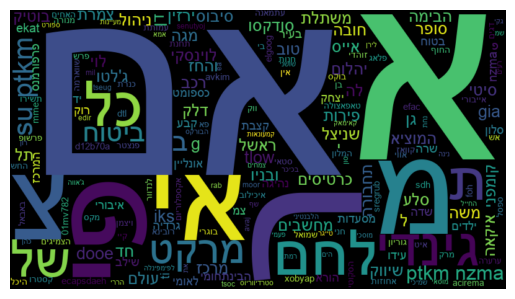

In [47]:
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# fe = NameExtractor(run_columns=['description'], replace_columns=[])
# extracted_data = df.apply(fe.extract, axis=1, result_type='expand')
extracted_data['description'] = df['description']
text_df = extracted_data['normalized'].unique()
ignore_list = {'paypal','בר','ישראל','שיק','זיכוי','מודיעין','מילואים','ת״א'}
text_filtered_list = []
text = ''
skip = False
for t in text_df.tolist():
    for _t in ignore_list:
        if _t in t:
            skip = True
    if not skip:
        text_filtered_list.append(t)
    else:
        skip = False
text = ' '.join(text_filtered_list)
assert 'paypal' not in text, "filter didn't work"
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=450, font_path='/System/Library/Fonts/Supplemental/Arial.ttf').generate(
    text[::-1])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.margins(x=0, y=0)
# plt.show()

In [44]:
[x for x in extracted_data['normalized'].unique() if 'ישראל' in x.lower()]

['רכבת ישראל',
 'פספורט כארד ישראל',
 "a i g ישראל חב' לביט",
 'די  אייץ  אל (ישראל']

## EDA over extracted features

In [10]:
from interface.predictive_model.category_classification_script import load_data, get_secrets, extract_features, CONFIG, clean_data

from pandas_profiling import ProfileReport
feature_extractors = CONFIG['feature_extractors']
clean_param = CONFIG['clean_param']

df = load_data(mysql_param=secrets)
df_extracted = extract_features(df, feature_extractors)
df_profile = clean_data(df_extracted, **clean_param)

In [11]:
df_profile.head()

,weekday,account_number,normalized,day,charged_amount,category,type,month
0,5,1,a i g ב. חובה חיתום,25,94.58,Car insurance,None,8
1,1,1,גרינהאוס,9,76.00,Food work,None,7
2,2,1,"שניצל קומפני ריב""ל",10,38.00,Food work,Restaurant,7
3,2,1,א מ י ב מרקט,10,42.70,Groceries,None,7
4,3,1,בריא בר,11,30.00,Food work,None,7


In [12]:
profile = ProfileReport(df_profile, title="Pandas Profiling Report")
profile.to_file("credits_eda.html")

/Users/noam.cohen/Library/Caches/pypoetry/virtualenvs/finance-lGLYToYy-py3.9/lib/python3.9/site-packages/multimethod/__init__.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]